# Equação do calor. Aproximação do problema de Dirichlet. Exemplo 1

Nesta notebook vamos comparar o desempenho de vários métodos de aproximação da solução do problema de Dirichlet homogêneo para a equação do calor, 

 \begin{align}
  \partial_t u&=k\partial_x^2u, \quad 0 < x < L, t>0;\\
  u(0,t)&=0,u(L,t)=0,\quad  t\geq 0;\\
  u(x,0)&=f(x),\quad 0 \leq x \leq  L.
 \end{align}

In [1]:
#NumPy é a principal biblioteca para cálculos científicos de Python. Ela disponibiliza o objeto multidimensional 
#arranjo, objetos derivados, e um conjuntos de rotinas para operações rápidas sobre arranjos.
import numpy as np
#SymPy é uma biblioteca para cálculos simbólicos como integração exata, derivação, 
#resolução de equações, expansão em série de Taylor, etc
import sympy as sp 
#pandas é uma ferramenta de código aberto construída sobre Python para análise e manipulação de dados 
import pandas as pd
#Para mostrar tabelas mais bonitas
from IPython.display import HTML
#Matplotlib é uma biblioteca abrangente para criar visualizações estáticas, animadas e interativas em Python
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Fonte a ser usada nas figuras geradas pela Matplotlib.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

Consideraremos como perfil inicial de temperatura $$f(x) = \text{sen } \left(\frac{n\pi}{L} x\right)$$. Nesse caso podemos calcular uma fórmula explícita para a solução $$u(x,t) = e^{-k \left(\frac{n\pi}{L}\right)^2t}\text{sen } \left(\frac{n\pi}{L} x\right)$$

Fixaremos os valores $k=L=1$ e $n=1$. 

In [3]:
#Valores das constantes do problema
k = 1
L = 1
n = 1
# função que implementa o perfil inicial de temperatura
def f(x):
    return np.sin(n*np.pi*x/L)
# fórmula da solução 
def u_exata(x,t):
    return np.exp(-(k*(n*np.pi/L)**2)*t)*np.sin((n*np.pi/L)*x)

In [4]:
#Valores das constantes para a discretização na horizontal

M = 30  # Quantidade de subintervalos na malha horizontal
dx = L / M # Tamanho do passo no espaço
# Malha horizontal com M+1 pontos
malha_x = np.linspace(0.0, L, num=M + 1)


## 1. Método das Diferenças Progressivas

Se aplicarmos o método de Euler ao sistema de EDOs acima, obtemos o método das diferenças progressivas, que, neste caso, pode ser escrito da forma 

\begin{align}
 u_{m,j+1}&=\lambda u_{m+1,j}+(1-2\lambda)u_{m,j}+\lambda u_{m-1,j},\quad m=1,...,M-1,j=0,...,N-1;\\
 u_{0,j}&=0,\quad j=0,...,N;\\
 u_{M,j}&=0,\quad j=0,...,N;\\ 
 u_{m,0}&=f(x_m),\quad m=1,...,M-1.
\end{align}
ou ainda
\begin{equation}
 U^{j+1}=A_{DP}\cdot U^j,\quad 1 \leq j \leq N-1; 
\end{equation}
onde $A_{DP} = I+\lambda A_L$ e $\lambda = \frac{k \Delta t}{(\Delta x)^2}$.

### 1.1 Implementação do método

In [5]:
#Escolha dos parâmetros para a discretização no tempo

lamda = 10  # lambda
dt = lamda * dx**2 / k  # Tamanho do passo no tempo
N = 100  # Número de passos no tempo

### Matriz (u_{m,j}) contendo a solução
u = np.zeros([M + 1, N + 1])
#Condição Inicial
u[:,0] = f(malha_x)

# Cálculo das aproximações para cada j.
for j in range(N):
    u[1:-1,j+1] = u[1:-1,j] + lamda * (u[2:,j] - 2 * u[1:-1,j] + u[:-2,j])

## 2. Método das Diferenças Regressivas

Se aplicarmos o método de Euler regressivo ao sistema de EDOs do método das Linhas, obteremos o método 
das Diferenças Regressivas, que pode ser escrito da forma 

\begin{align}
 &-\lambda u_{m+1,j+1}+(1+2\lambda) u_{m,j+1}-\lambda u_{m-1,j+1}=u_{m,j},\quad m=1,...,M-1,j=0,...,N-1;\\
 &u_{0,j} = 0,\quad j=0,...,N;\\
 &u_{M,j} = 0,\quad j=0,...,N;\\ 
 &u_{m,0} = f(x_m),\quad m=1,...,M-1.
\end{align}
ou ainda
\begin{equation}
 A_{DR}U^{j+1}=U^j,\quad 1 \leq j \leq N-1; 
\end{equation}
onde $A_{DR} = I-\lambda A_L$.

### 3.1 Implementação do método

In [6]:
# Método de Thomas para resolver sistemas com matriz tridiagonal
# pode ser melhorado aproveitando que os coeficientes são constantes?
def Thomas(a, b, c1, d1):
    nmax = len(d1)#n em números é linhas
    
    # copias de c e d
    c = c1.copy()
    d = d1.copy()
    # Modifica o primeiro coeficiente de cada linha
    c[0] /= b[0] # Risco de divisão por zero.
    d[0] /= b[0]

    for i in range(1, nmax):
        ptemp = b[i] - a[i] * c[i-1]
        c[i] /= ptemp
        d[i] = (d[i] - a[i] * d[i-1])/ptemp

    # Substituição de volta
    v = [0 for i in range(nmax)]
    v[-1] = d[-1]
    for i in range(-2,-nmax-1,-1):
        v[i] = d[i] - c[i] * v[i+1]
    return v

In [7]:
#Escolha dos parâmetros

lamda1 = lamda # lambda
dt1 = lamda1 * dx**2 / k  # Tamanho do passo no tempo

N1 = N  # Número de passos no tempo

### Matriz (u_{m,j}) contendo a solução
u1 = np.zeros([M + 1, N1 + 1])
#Condição Inicial
u1[:,0] = f(malha_x)

#Matriz A_{DR}
alfa = -lamda1 * np.ones(M-1)
alfa[0] = 0
beta = (1+2*lamda1)*np.ones(M-1)
gamma = -lamda1 * np.ones(M-1)
gamma[-1] = 0

# Cálculo das aproximações para cada j.
for j in range(N1):
    u1[1:-1,j+1] = Thomas(alfa, beta, gamma, u1[1:-1,j])

## 3. Método de Crank - Nicolson

Se aplicarmos o método trapezoidal ao sistema de EDOs do método das Linhas, obteremos o método 
de Crank - Nicolson, que pode ser escrito da forma 

\begin{align}
  -\lambda u_{m+1,j+1}+ 2(1+\lambda)u_{m,j+1}-\lambda u_{m-1,j+1} &=\lambda u_{m+1,j}+2(1-\lambda)u_{m,j}+\lambda u_{m-1,j},\quad m=1,...,M-1,j=0,...,N-1;\\
 &u_{0,j} = 0,u_{M,j} = 0, \quad j=0,...,N;\\ 
 &u_{m,0} = f(x_m),\quad m=1,...,M-1.
\end{align}
ou ainda
\begin{equation}
 \left[2I-\lambda A_L\right] U^{j+1} = \left[2I+\lambda A_L\right] U^{j},\quad 1 \leq j \leq N-1. 
\end{equation}


### 3.1 Implementação do método

In [8]:
#Escolha dos parâmetros

lamda2 = lamda  # lambda
dt2 = lamda2 * dx**2 / k  # Tamanho do passo no tempo

N2 = 10  # Número de passos no tempo

### Matriz (u_{m,j}) contendo a solução
u2 = np.zeros([M + 1, N2 + 1])
#Condição Inicial
u2[:,0] = f(malha_x)

#Matriz 2I-lambda A
alfa2 = -lamda2 * np.ones(M-1)
alfa2[0] = 0
beta2 = 2*(1+lamda2)*np.ones(M-1)
gamma2 = -lamda2 * np.ones(M-1)
gamma2[-1] = 0

# Cálculo das aproximações para cada j.
for j in range(N2):    
    delta2 = 2*u2[1:-1,j] + lamda2 * (u2[2:,j] - 2 * u2[1:-1,j] + u2[:-2,j])
    u2[1:-1,j+1] = Thomas(alfa2, beta2, gamma2, delta2)    

## 4. Visualização das soluções aproximadas e da solução exata.

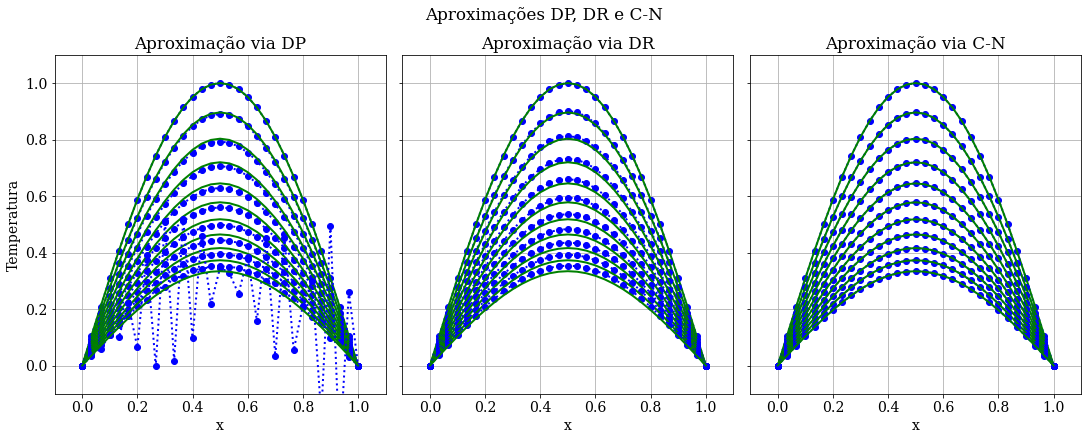

In [10]:
# Plotar a solução
# Tamanho da letra nas figuras do Matplotlib.
plt.rcParams['font.size'] = 14
# Plotagem da solução exata junto com as aproximações obtidas.
# Tamanho da figura e janelas
figsize = (15, 6)
colunas = 3
linhas = 1
fig, axs = plt.subplots(linhas, colunas, figsize=figsize, constrained_layout=True,sharey=True)
fig.suptitle('Aproximações DP, DR e C-N')
axs[0].set_ylabel('Temperatura')
axs[0].set_xlabel('x')
axs[1].set_xlabel('x')
axs[2].set_xlabel('x')
axs[0].set_title('Aproximação via DP')
axs[1].set_title('Aproximação via DR')
axs[2].set_title('Aproximação via C-N')
axs[0].set_xlim(-0.1,L+0.1)
axs[1].set_xlim(-0.1,L+0.1)
axs[2].set_xlim(-0.1,L+0.1)
axs[0].set_ylim(-0.1,L+0.1)
axs[1].set_ylim(-0.1,L+0.1)
axs[2].set_ylim(-0.1,L+0.1)
for j in range(0,N2+1):
    axs[0].plot(malha_x, u[:,j], 'o:', linewidth=2, color = 'blue')
    axs[0].plot(malha_x, u_exata(malha_x,j*dt), linestyle='-', linewidth=2, color = 'green')    
    axs[1].plot(malha_x, u1[:,j], 'o:', linewidth=2, color = 'blue') 
    axs[1].plot(malha_x, u_exata(malha_x,j*dt1), linestyle='-', linewidth=2, color = 'green')    
    axs[2].plot(malha_x, u2[:,j], 'o:', linewidth=2, color = 'blue')
    axs[2].plot(malha_x, u_exata(malha_x,j*dt2), linestyle='-', linewidth=2, color = 'green')    
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True);
#plt.legend();